<a href="https://colab.research.google.com/github/jared-ni/cs2241-final/blob/main/5_9_2025_bloomier-filter-fpp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import os

In [2]:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import kagglehub
import os
import pathlib
import matplotlib.pyplot as plt
import time

print("TensorFlow Version:", tf.__version__)

gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(f"Found GPU: {gpu_devices[0].name}. Training will be accelerated.")
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print("No GPU found. Training will run on CPU (might be slow).")
    print("Runtime > Change runtime type > Hardware accelerator > GPU")

TensorFlow Version: 2.18.0
Found GPU: /physical_device:GPU:0. Training will be accelerated.


In [4]:
import kagglehub
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import pathlib

# data_root = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")
data_root = kagglehub.dataset_download("alessiocorrado99/animals10")

data_dir = os.path.join(data_root, 'raw-img')

print("Path to dataset files:", data_dir)

Path to dataset files: /kaggle/input/animals10/raw-img


In [5]:
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
import os
import shutil
import random
from tqdm import tqdm

output_base_dir = "/kaggle/split_data-animals10"

# Output folders
output_dirs = {
    'train': os.path.join(output_base_dir, 'train'),
    'val': os.path.join(output_base_dir, 'val'),
    'test': os.path.join(output_base_dir, 'test')
}

# Classes (folder names in PetImages/)
# classes = ['Cat', 'Dog']
classes = ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
split_ratio = [0.8, 0.1, 0.1]

# Create output folders
for split in output_dirs:
    for cls in classes:
        os.makedirs(os.path.join(output_dirs[split], cls), exist_ok=True)

print("Path to output files:", output_dirs)
# Split images
for cls in classes:
    src_folder = os.path.join(data_dir, cls)
    all_files = [f for f in os.listdir(src_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(all_files)

    total_used = 1000

    train_cutoff = int(total_used * split_ratio[0])
    val_cutoff = int(total_used * (split_ratio[0] + split_ratio[1]))

    splits = {
        'train': all_files[:train_cutoff],
        'val': all_files[train_cutoff:val_cutoff],
        'test': all_files[val_cutoff:total_used]
    }

    for split, files in splits.items():
        for f in tqdm(files, desc=f"Copying {cls} to {split}"):
            src = os.path.join(src_folder, f)
            dst = os.path.join(output_dirs[split], cls, f)
            try:
                shutil.copyfile(src, dst)
            except Exception as e:
                pass  # Skip corrupted files


Path to output files: {'train': '/kaggle/split_data-animals10/train', 'val': '/kaggle/split_data-animals10/val', 'test': '/kaggle/split_data-animals10/test'}


Copying cane to train:  60%|██████    | 484/800 [00:03<00:02, 126.81it/s]


KeyboardInterrupt: 

In [7]:
# IMAGENET FEATURE MAP EXTRACTION (512, 7, 7)
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os

# 1. Load VGG16 pre-trained on ImageNet
print("Loading VGG16 pre-trained on ImageNet...")
vgg16 = models.vgg16(pretrained=True)
print("Model loaded.")

# Get the convolutional base (features)
spatial_feature_extractor_vgg = vgg16.features

# Freeze the weights of the pre-trained layers
for param in spatial_feature_extractor_vgg.parameters():
    param.requires_grad = False

# Set the model to evaluation mode (important for dropout if it were present, or batch norm if it were ResNet etc.)
spatial_feature_extractor_vgg.eval() # Do this once after setup

print("\nVGG16 Spatial Feature Extractor created and set to eval mode.")
print(f"Conceptual output shape (spatial features for 224x224 input): (Batch_Size, 512, 7, 7)")

img_height, img_width = 224, 224

preprocess = transforms.Compose([
    # 1. Resize the image
    transforms.Resize((img_height, img_width)),
    # 2. Convert PIL Image to PyTorch Tensor
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Loading VGG16 pre-trained on ImageNet...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
 68%|██████▊   | 359M/528M [00:01<00:00, 209MB/s]


KeyboardInterrupt: 

In [9]:
def extract_features_from_image_path(image_path: str) -> torch.Tensor:
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found at: {image_path}")
    try:
        # Load the image using PIL
        img_pil = Image.open(image_path)
        if img_pil.mode != 'RGB':
            img_pil = img_pil.convert('RGB')
        processed_img_th = preprocess(img_pil)
        input_tensor = processed_img_th.unsqueeze(0)

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        raise
    with torch.no_grad():
        spatial_features = spatial_feature_extractor_vgg(input_tensor)
    return spatial_features

my_image_path = '/kaggle/split_data/test/Cat/100.jpg'
stats_output_file = 'feature_map_stats.txt'
full_feature_map_file = 'full_feature_map.txt'

if not os.path.exists(my_image_path):
    print(f"Example image not found at {my_image_path}. Please update the path.")
else:
    print(f"\n--- Extracting features for {my_image_path} ---")

# get the feature map
feature_map = extract_features_from_image_path(my_image_path)

# Print the shape and some info to console
print(f"\nSuccessfully extracted feature map.")
print(f"Feature map shape: {feature_map.shape}")
print(f"Feature map dtype: {feature_map.dtype}")

# --- Calculate summary statistics ---
min_val = torch.min(feature_map)
max_val = torch.max(feature_map)
mean_val = torch.mean(feature_map)
std_val = torch.std(feature_map)

# --- Print summary statistics to console ---
print("\n--- Summary statistics of the extracted feature map ---")
print(f"Min value: {min_val}")
print(f"Max value: {max_val}")
print(f"Mean value: {mean_val}")
print(f"Standard deviation: {std_val}")

# --- Optional: Print a slice to console ---
print("\n--- Slice of the feature map (Batch 0, first 5 channels, H=0, W=0) ---")
print(feature_map[0, :5, 0, 0])


# --- Write summary statistics to the stats text file ---
print(f"\nWriting summary statistics to {stats_output_file}...")
with open(stats_output_file, 'w') as f:
    f.write(f"Feature Map Statistics for Image: {my_image_path}\n")
    f.write("-" * 40 + "\n")
    f.write(f"Feature map shape: {feature_map.shape}\n")
    f.write(f"Feature map dtype: {feature_map.dtype}\n")
    f.write("-" * 40 + "\n")
    f.write(f"Min value: {min_val.item()}\n") # Use .item() to get scalar value
    f.write(f"Max value: {max_val.item()}\n")
    f.write(f"Mean value: {mean_val.item()}\n")
    f.write(f"Standard deviation: {std_val.item()}\n")
    f.write("-" * 40 + "\n")

    print(f"Summary statistics successfully written to {stats_output_file}.")
    print(f"\nWriting the FULL feature map content to {full_feature_map_file}...")

np.save("feature_map_nparray.npy", feature_map.numpy())

Example image not found at /kaggle/split_data/test/Cat/100.jpg. Please update the path.


FileNotFoundError: Image file not found at: /kaggle/split_data/test/Cat/100.jpg

In [10]:
# IMAGENET 4096 FEATURE EXTRACTION SETUP
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image # Import PIL for loading images
import numpy as np
import os
import traceback # Import traceback for detailed error printing

# 1. Load VGG16 pre-trained on ImageNet
print("Loading VGG16 pre-trained on ImageNet...")
vgg16 = models.vgg16(pretrained=True)
print("Model loaded.")

# 2. Create the feature extractor as a custom Module, explicitly handling Flatten
class VGG16FeatureExtractor4096(nn.Module):
    def __init__(self, original_vgg16):
        super().__init__()
        # Keep the convolutional base (output is 512x7x7 for 224x224 input)
        self.features = original_vgg16.features

        # Manually add the Flatten layer
        self.flatten = nn.Flatten()

        self.classifier_head = nn.Sequential(
             original_vgg16.classifier[0], # First Linear layer (25088 -> 4096)
             original_vgg16.classifier[1]  # ReLU after it
        )

        for param in original_vgg16.parameters():
             param.requires_grad = False
    def forward(self, x):
        # Pass through the convolutional base
        x = self.features(x) # Output shape: (Batch, 512, 7, 7)
        x = self.flatten(x) # Expected output shape: (Batch, 512 * 7 * 7) = (Batch, 25088)
        x = self.classifier_head(x) # Output shape: (Batch, 4096)
        return x

# Instantiate the custom feature extractor
feature_extractor_vgg_4096 = VGG16FeatureExtractor4096(vgg16)
feature_extractor_vgg_4096.eval()

print("\nVGG16 4096-element Feature Extractor (Custom Module V2) created and set to eval mode.")
print(f"Conceptual output shape (4096 features for 224x224 input): (Batch_Size, 4096)")

img_height, img_width = 224, 224

preprocess = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

print("\nPreprocessing pipeline imagenet 4096 defined.")

Loading VGG16 pre-trained on ImageNet...


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
 39%|███▉      | 207M/528M [00:01<00:01, 192MB/s]


KeyboardInterrupt: 

In [11]:
def extract_4096_features_from_image_path(image_path: str) -> torch.Tensor:
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found at: {image_path}")
    try:
        img_pil = Image.open(image_path)
        if img_pil.mode != 'RGB':
            img_pil = img_pil.convert('RGB')
        processed_img_th = preprocess(img_pil)
        input_tensor = processed_img_th.unsqueeze(0)

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        raise # Re-raise the exception

    with torch.no_grad():
        features_4096 = feature_extractor_vgg_4096(input_tensor)

    return features_4096

In [12]:

# Make sure you have an image file at this path!
my_image_path = '/kaggle/split_data-animals10/test/cane/OIP--OzHmoOBxcUQs7N3KjButwHaFP.jpeg' # <--- Use your specific test path
feature_vector_output_file = 'image_feature_vector_4096.txt' # <--- Define the output file path

if not os.path.exists(my_image_path):
    print(f"Example image not found at {my_image_path}. Please update the path.")
else:
    print(f"\n--- Extracting 4096 features for {my_image_path} ---")
    # Call the function to get the 4096 feature vector
    feature_vector_4096 = extract_4096_features_from_image_path(my_image_path)

    # Print the shape and some info
    print(f"\nSuccessfully extracted 4096 feature vector.")
    print(f"Feature vector shape: {feature_vector_4096.shape}") # Should be (1, 4096)
    print(f"Feature vector dtype: {feature_vector_4096.dtype}")

    print("\n--- Summary statistics of the extracted 4096 feature vector ---")
    print(f"Min value: {torch.min(feature_vector_4096).item()}")
    print(f"Max value: {torch.max(feature_vector_4096).item()}")
    print(f"Mean value: {torch.mean(feature_vector_4096).item()}")
    print(f"Standard deviation: {torch.std(feature_vector_4096).item()}")

    # --- Write the FULL 4096 feature vector to a text file ---
    print(f"\nWriting the FULL 4096 feature vector to {feature_vector_output_file}...")

    # The tensor is (1, 4096). We want the 4096 values from the first (and only) item in the batch.
    # Convert the tensor to a NumPy array, then flatten it to a 1D array, then convert to a list.
    feature_list = feature_vector_4096.tolist()
    feature_string = str(feature_list)

    # Write this string representation to the file
    with open(feature_vector_output_file, 'w') as f:
        f.write(f"Feature Vector (4096 elements) for Image: {my_image_path}\n")
        f.write("-" * 40 + "\n")
        f.write(f"Shape: {feature_vector_4096.shape}, Dtype: {feature_vector_4096.dtype}\n")
        f.write("-" * 40 + "\n")
        # Write the single, potentially very long, string
        f.write(feature_string)
        f.write("\n") # Add a newline at the end
    np.save("feature_vector_4096_nparray.npy", feature_vector_4096.numpy())

Example image not found at /kaggle/split_data-animals10/test/cane/OIP--OzHmoOBxcUQs7N3KjButwHaFP.jpeg. Please update the path.


In [ ]:
def process_dataset_and_save_features(input_base_dir, output_base_dir):
    """
    Iterates through the dataset directory structure, extracts features for each image,
    and saves them as .npy files in a mirrored directory structure.
    """
    if not os.path.exists(input_base_dir):
        print(f"ERROR: Input dataset directory not found: {input_base_dir}")
        return

    print(f"\nStarting feature extraction for dataset at: {input_base_dir}")
    print(f"Features will be saved under: {output_base_dir}")

    # Ensure the main output directory exists
    os.makedirs(output_base_dir, exist_ok=True)

    # Iterate through 'test', 'train', 'val' subfolders
    for split_name in os.listdir(input_base_dir):
        split_dir = os.path.join(input_base_dir, split_name)
        if not os.path.isdir(split_dir):
            continue
        print(f"\nProcessing split: {split_name}")

        # Create corresponding split directory in output
        output_split_dir = os.path.join(output_base_dir, split_name)
        os.makedirs(output_split_dir, exist_ok=True)

        # Iterate through 'Cat', 'Dog' sub-subfolders
        for class_name in os.listdir(split_dir):
            class_dir = os.path.join(split_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            print(f"  Processing class: {class_name}")

            # Create corresponding class directory in output
            output_class_dir = os.path.join(output_split_dir, class_name)
            os.makedirs(output_class_dir, exist_ok=True)

            # Iterate through images in the class directory
            processed_in_class_count = 0
            image_files_in_class = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

            for image_name in image_files_in_class:
                image_path = os.path.join(class_dir, image_name)

                # Construct the output feature file path
                base_name, _ = os.path.splitext(image_name)
                feature_file_name = f"{base_name}_feature_vector.npy"
                feature_file_path = os.path.join(output_class_dir, feature_file_name)

                try:
                    # Extract the 4096 feature vector (PyTorch tensor, shape (1, 4096))
                    feature_vector_tensor = extract_4096_features_from_image_path(image_path)

                    # Convert to NumPy array and remove the batch dimension
                    # Squeeze(0) converts from (1, 4096) to (4096,)
                    feature_vector_np = feature_vector_tensor.squeeze(0).numpy()

                    # Save the NumPy array
                    np.save(feature_file_path, feature_vector_np)

                    processed_in_class_count += 1
                    if processed_in_class_count % 50 == 0 or processed_in_class_count == len([f for f in image_files_in_class]): # Log progress
                        valid_image_count = len([f for f in image_files_in_class])
                        print(f"    Saved features for {processed_in_class_count}/{valid_image_count} images in {split_name}/{class_name}...")

                except Exception as e:
                    print(f"    ERROR extracting/saving features for {image_name}: {e}")
                    # traceback.print_exc() # Uncomment for full traceback if needed for debugging

            print(f"  Finished processing class {class_name}. Extracted features for {processed_in_class_count} images.")
        print(f"Finished processing split {split_name}.")

    print("\nAll feature extraction complete.")


# Process the dataset
OUTPUT_FEATURES_BASE_DIR = '/kaggle/feature_vectors-animals10'
INPUT_DATA_BASE_DIR = '/kaggle/split_data-animals10'
process_dataset_and_save_features(INPUT_DATA_BASE_DIR, OUTPUT_FEATURES_BASE_DIR)

In [ ]:
!zip -r /content/feature_vectors-animals10.zip /kaggle/feature_vectors-animals10
from google.colab import files
files.download("/content/feature_vectors-animals10.zip")

In [ ]:

!unzip "/content/3-bloomier-fpp-experiments.zip" -d "/content/3-bloomier-fpp-experiments"

In [15]:
# ------------------------------------------------------------
# --- Imports ---
# ------------------------------------------------------------
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader # For data loading and batching
from sklearn.model_selection import train_test_split # Still useful if you needed to split data here


# ------------------------------------------------------------
# --- Configuration ---
# ------------------------------------------------------------
# Path to the directory where you saved the extracted feature vectors
# !!! CHANGE THIS TO YOUR ACTUAL SAVED FEATURES PATH !!!
# SAVED_FEATURES_BASE_DIR = '/content/decompressed_4bit-quant_count-min_05/decompressed_05_everything'

# Label mapping (must match how features were extracted)
# Ensure these map to 0 and 1 for binary classification
# LABEL_MAP = {'Cat': 0, 'Dog': 1} # Cat = 0, Dog = 1
LABEL_MAP = {'cane': 0, 'cavallo': 1, 'elefante': 2, 'farfalla': 3, 'gallina': 4, 'gatto': 5,
             'mucca': 6, 'pecora': 7, 'ragno': 8, 'scoiattolo': 9}

# --- Classifier Model Parameters ---
INPUT_FEATURE_DIM = 4096 # VGG16 4096 feature vector size
# NUM_CLASSES = 2
NUM_CLASSES = 10

# --- Training Hyperparameters ---
EPOCHS = 50 # Number of training epochs (you might adjust this)
BATCH_SIZE = 8 # Training batch size (you might adjust this)
LEARNING_RATE = 0.001 # Learning rate for optimizer (Adam is a good default)

# --- Device Configuration ---
# Use GPU if available, otherwise use CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


# ------------------------------------------------------------
# --- Data Loading Function (from .npy files) ---
# ------------------------------------------------------------

def load_features_and_labels_from_dir(features_base_dir, split_name, label_map):
    """
    Loads feature vectors and labels from .npy files saved in a directory structure.

    Args:
        features_base_dir: The base directory containing the split folders (e.g., '/kaggle/feature_vectors').
        split_name: The name of the split folder to load ('train', 'val', or 'test').
        label_map: Dictionary mapping class names (folder names) to numerical labels.

    Returns:
        A tuple containing:
        - features: A NumPy array of shape (num_samples, INPUT_FEATURE_DIM).
        - labels: A NumPy array of shape (num_samples,) containing numerical labels.
    """
    split_dir = os.path.join(features_base_dir, split_name)
    if not os.path.exists(split_dir):
        raise FileNotFoundError(f"Split directory not found: {split_dir}")

    all_features = []
    all_labels = []

    print(f"Loading features from split: {split_dir}")

    # Iterate through class folders ('Cat', 'Dog') based on the provided label_map
    for class_name, label in label_map.items():
        class_dir = os.path.join(split_dir, class_name)
        if not os.path.isdir(class_dir):
            print(f"  Warning: Class directory not found: {class_dir}. Skipping.")
            continue

        print(f"  Loading features for class: {class_name}")
        npy_files = [f for f in os.listdir(class_dir) if f.lower().endswith('.npy')]

        loaded_count = 0
        for npy_file in npy_files:
            file_path = os.path.join(class_dir, npy_file)
            try:
                # Load the .npy file
                feature_vector = np.load(file_path)

                # Ensure the shape is correct (should be (4096,))
                if feature_vector.shape != (INPUT_FEATURE_DIM,):
                    print(f"    Warning: Unexpected shape {feature_vector.shape} for {npy_file}. Skipping.")
                    continue

                all_features.append(feature_vector)
                all_labels.append(label) # Append the numerical label

                loaded_count += 1
                if loaded_count > 0 and loaded_count % 1000 == 0: # Print progress
                     print(f"    Loaded {loaded_count}/{len(npy_files)} files for {class_name}...")

            except Exception as e:
                print(f"    Error loading {npy_file}: {e}. Skipping.")

        print(f"  Finished loading {loaded_count} files for class {class_name}.")


    # Convert lists to NumPy arrays
    features = np.array(all_features)
    labels = np.array(all_labels)

    print(f"Finished loading split {split_name}.")
    print(f"  Loaded {len(features)} total samples.")

    return features, labels


class FeatureDataset(Dataset):
    """Custom Dataset for loading feature vectors and labels."""
    def __init__(self, features_np, labels_np):
        self.features = torch.from_numpy(features_np).float()
        self.labels = torch.from_numpy(labels_np).long()

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


class FeatureClassifier(nn.Module):
    def __init__(self, input_dim, num_classes=NUM_CLASSES):
        super().__init__()
        # Simple feed-forward network (MLP)
        self.layer_1 = nn.Linear(input_dim, 256) # Input layer to hidden layer 1
        self.relu_1 = nn.ReLU()
        self.dropout_1 = nn.Dropout(0.5) # Dropout for regularization

        # Optional: Add another hidden layer if needed
        # self.layer_2 = nn.Linear(256, 128)
        # self.relu_2 = nn.ReLU()
        # self.dropout_2 = nn.Dropout(0.5)

        # Output layer
        # Output size is num_classes (2 for Cat/Dog)
        self.output_layer = nn.Linear(256, num_classes) # Connect last hidden layer to output

    def forward(self, x):
        # Define the forward pass
        x = self.layer_1(x)
        x = self.relu_1(x)
        x = self.dropout_1(x)

        # If you added layer_2:
        # x = self.layer_2(x)
        # x = self.relu_2(x)
        # x = self.dropout_2(x)

        x = self.output_layer(x)
        return x


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model.train() # Set model to training mode

    for epoch in range(num_epochs):
        running_loss = 0.0
        train_corrects = 0
        train_total = 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device) # Move data to device

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Track training statistics
            running_loss += loss.item() * inputs.size(0) # Accumulate loss
            _, predicted = torch.max(outputs.data, 1)     # Get predicted class
            train_total += labels.size(0)                 # Count total samples
            train_corrects += (predicted == labels).sum().item() # Count correct predictions

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = train_corrects / train_total

        # Evaluation on validation set
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)

        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} - Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Set model back to training mode for the next epoch
        model.train()


def evaluate_model(model, data_loader, criterion, device):
    model.eval() # Set model to evaluation mode
    running_loss = 0.0
    corrects = 0
    total = 0

    # Disable gradient calculation for evaluation
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device) # Move data to device

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            corrects += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = corrects / total

    return epoch_loss, epoch_acc

Using device: cuda


In [16]:

# ------------------------------------------------------------
# Bloom filter EPP (bloom_fpp=0.2, cm_epsilon=0.01, cm_delta=0.01, 4bit quant) experiment
# ------------------------------------------------------------

SAVED_FEATURES_BASE_DIR = '/content/3-bloomier-fpp-experiments/3-bloomier-fpp-experiments/dict_animals10-10k_bloomier_fpp001/decompressed'

if __name__ == "__main__":
    print("\n--- PyTorch Classifier Training ---")

    # 1. Load Data from .npy files
    try:
        X_train_np, y_train_np = load_features_and_labels_from_dir(SAVED_FEATURES_BASE_DIR, 'train', LABEL_MAP)
        X_val_np, y_val_np = load_features_and_labels_from_dir(SAVED_FEATURES_BASE_DIR, 'val', LABEL_MAP)
        X_test_np, y_test_np = load_features_and_labels_from_dir(SAVED_FEATURES_BASE_DIR, 'test', LABEL_MAP)
    except FileNotFoundError as e:
         print(f"Data loading failed: {e}")
         print("Please ensure SAVED_FEATURES_BASE_DIR is correct and .npy files exist.")
         exit() # Exit if data cannot be loaded

    if len(X_train_np) == 0:
        print("\nERROR: No training features loaded. Cannot proceed.")
        exit()


    # 2. Create Datasets and DataLoaders
    print("\nCreating Datasets and DataLoaders...")
    train_dataset = FeatureDataset(X_train_np, y_train_np)
    val_dataset = FeatureDataset(X_val_np, y_val_np)
    test_dataset = FeatureDataset(X_test_np, y_test_np)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) # Shuffle training data
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print("Datasets and DataLoaders created.")
    print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")


    # 3. Define the PyTorch Classifier Model
    print("\nDefining PyTorch Classifier Model...")
    model = FeatureClassifier(INPUT_FEATURE_DIM, NUM_CLASSES)
    model.to(DEVICE) # Move model to the configured device (CPU/GPU)
    print("Model Architecture:")
    print(model)


    # 4. Define Loss Function and Optimizer
    print("\nDefining Loss and Optimizer...")
    criterion = nn.CrossEntropyLoss() # Suitable for classification with raw logits
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # Adam optimizer


    # 5. Train the Model
    print("\n--- Training Classifier Model ---")
    train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS, DEVICE)


    # 6. Evaluate the Model on Test Set
    print("\n--- Evaluating Classifier Model on Test Set ---")
    test_loss, test_acc = evaluate_model(model, test_loader, criterion, DEVICE)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}')

    print("\nClassifier training and evaluation finished.")
    print("The trained PyTorch model is stored in the 'model' variable.")
    # You can save the trained model weights: torch.save(model.state_dict(), 'classifier_weights.pth')


--- PyTorch Classifier Training ---
Loading features from split: /content/3-bloomier-fpp-experiments/3-bloomier-fpp-experiments/dict_animals10-10k_bloomier_fpp001/decompressed/train
  Loading features for class: cane
  Finished loading 800 files for class cane.
  Loading features for class: cavallo
  Finished loading 800 files for class cavallo.
  Loading features for class: elefante
  Finished loading 800 files for class elefante.
  Loading features for class: farfalla
  Finished loading 800 files for class farfalla.
  Loading features for class: gallina
  Finished loading 800 files for class gallina.
  Loading features for class: gatto
  Finished loading 800 files for class gatto.
  Loading features for class: mucca
  Finished loading 800 files for class mucca.
  Loading features for class: pecora
  Finished loading 800 files for class pecora.
  Loading features for class: ragno
  Finished loading 800 files for class ragno.
  Loading features for class: scoiattolo
  Finished loading

In [17]:

# ------------------------------------------------------------
# Bloom filter EPP (bloom_fpp=0.3, cm_epsilon=0.01, cm_delta=0.01, 4bit quant) experiment
# ------------------------------------------------------------

SAVED_FEATURES_BASE_DIR = '/content/3-bloomier-fpp-experiments/3-bloomier-fpp-experiments/dict_animals10-10k_bloomier_fpp01/decompressed'
if __name__ == "__main__":
    print("\n--- PyTorch Classifier Training ---")

    # 1. Load Data from .npy files
    try:
        X_train_np, y_train_np = load_features_and_labels_from_dir(SAVED_FEATURES_BASE_DIR, 'train', LABEL_MAP)
        X_val_np, y_val_np = load_features_and_labels_from_dir(SAVED_FEATURES_BASE_DIR, 'val', LABEL_MAP)
        X_test_np, y_test_np = load_features_and_labels_from_dir(SAVED_FEATURES_BASE_DIR, 'test', LABEL_MAP)
    except FileNotFoundError as e:
         print(f"Data loading failed: {e}")
         print("Please ensure SAVED_FEATURES_BASE_DIR is correct and .npy files exist.")
         exit() # Exit if data cannot be loaded

    if len(X_train_np) == 0:
        print("\nERROR: No training features loaded. Cannot proceed.")
        exit()


    # 2. Create Datasets and DataLoaders
    print("\nCreating Datasets and DataLoaders...")
    train_dataset = FeatureDataset(X_train_np, y_train_np)
    val_dataset = FeatureDataset(X_val_np, y_val_np)
    test_dataset = FeatureDataset(X_test_np, y_test_np)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) # Shuffle training data
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print("Datasets and DataLoaders created.")
    print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")


    # 3. Define the PyTorch Classifier Model
    print("\nDefining PyTorch Classifier Model...")
    model = FeatureClassifier(INPUT_FEATURE_DIM, NUM_CLASSES)
    model.to(DEVICE) # Move model to the configured device (CPU/GPU)
    print("Model Architecture:")
    print(model)


    # 4. Define Loss Function and Optimizer
    print("\nDefining Loss and Optimizer...")
    criterion = nn.CrossEntropyLoss() # Suitable for classification with raw logits
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # Adam optimizer


    # 5. Train the Model
    print("\n--- Training Classifier Model ---")
    train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS, DEVICE)


    # 6. Evaluate the Model on Test Set
    print("\n--- Evaluating Classifier Model on Test Set ---")
    test_loss, test_acc = evaluate_model(model, test_loader, criterion, DEVICE)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}')

    print("\nClassifier training and evaluation finished.")
    print("The trained PyTorch model is stored in the 'model' variable.")
    # You can save the trained model weights: torch.save(model.state_dict(), 'classifier_weights.pth')


--- PyTorch Classifier Training ---
Loading features from split: /content/3-bloomier-fpp-experiments/3-bloomier-fpp-experiments/dict_animals10-10k_bloomier_fpp01/decompressed/train
  Loading features for class: cane
  Finished loading 800 files for class cane.
  Loading features for class: cavallo
  Finished loading 800 files for class cavallo.
  Loading features for class: elefante
  Finished loading 800 files for class elefante.
  Loading features for class: farfalla
  Finished loading 800 files for class farfalla.
  Loading features for class: gallina
  Finished loading 800 files for class gallina.
  Loading features for class: gatto
  Finished loading 800 files for class gatto.
  Loading features for class: mucca
  Finished loading 800 files for class mucca.
  Loading features for class: pecora
  Finished loading 800 files for class pecora.
  Loading features for class: ragno
  Finished loading 800 files for class ragno.
  Loading features for class: scoiattolo
  Finished loading 

In [18]:

# ------------------------------------------------------------
# --- Main Execution ---
# ------------------------------------------------------------

SAVED_FEATURES_BASE_DIR = '/content/3-bloomier-fpp-experiments/3-bloomier-fpp-experiments/dict_animals10-10k_bloomier_fpp03/decompressed'

if __name__ == "__main__":
    print("\n--- PyTorch Classifier Training ---")

    # 1. Load Data from .npy files
    try:
        X_train_np, y_train_np = load_features_and_labels_from_dir(SAVED_FEATURES_BASE_DIR, 'train', LABEL_MAP)
        X_val_np, y_val_np = load_features_and_labels_from_dir(SAVED_FEATURES_BASE_DIR, 'val', LABEL_MAP)
        X_test_np, y_test_np = load_features_and_labels_from_dir(SAVED_FEATURES_BASE_DIR, 'test', LABEL_MAP)
    except FileNotFoundError as e:
         print(f"Data loading failed: {e}")
         print("Please ensure SAVED_FEATURES_BASE_DIR is correct and .npy files exist.")
         exit() # Exit if data cannot be loaded

    if len(X_train_np) == 0:
        print("\nERROR: No training features loaded. Cannot proceed.")
        exit()


    # 2. Create Datasets and DataLoaders
    print("\nCreating Datasets and DataLoaders...")
    train_dataset = FeatureDataset(X_train_np, y_train_np)
    val_dataset = FeatureDataset(X_val_np, y_val_np)
    test_dataset = FeatureDataset(X_test_np, y_test_np)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) # Shuffle training data
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print("Datasets and DataLoaders created.")
    print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")

    print(f"Length of training dataset: {len(train_loader.dataset)}")
    print(f"Length of validation dataset: {len(val_loader.dataset)}")

    # 3. Define the PyTorch Classifier Model
    print("\nDefining PyTorch Classifier Model...")
    model = FeatureClassifier(INPUT_FEATURE_DIM, NUM_CLASSES)
    model.to(DEVICE) # Move model to the configured device (CPU/GPU)
    print("Model Architecture:")
    print(model)


    # 4. Define Loss Function and Optimizer
    print("\nDefining Loss and Optimizer...")
    criterion = nn.CrossEntropyLoss() # Suitable for classification with raw logits
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # Adam optimizer


    # 5. Train the Model
    print("\n--- Training Classifier Model ---")
    train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS, DEVICE)


    # 6. Evaluate the Model on Test Set
    print("\n--- Evaluating Classifier Model on Test Set ---")
    test_loss, test_acc = evaluate_model(model, test_loader, criterion, DEVICE)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}')

    print("\nClassifier training and evaluation finished.")
    print("The trained PyTorch model is stored in the 'model' variable.")
    # You can save the trained model weights: torch.save(model.state_dict(), 'classifier_weights.pth')


--- PyTorch Classifier Training ---
Loading features from split: /content/3-bloomier-fpp-experiments/3-bloomier-fpp-experiments/dict_animals10-10k_bloomier_fpp03/decompressed/train
  Loading features for class: cane
  Finished loading 800 files for class cane.
  Loading features for class: cavallo
  Finished loading 800 files for class cavallo.
  Loading features for class: elefante
  Finished loading 800 files for class elefante.
  Loading features for class: farfalla
  Finished loading 800 files for class farfalla.
  Loading features for class: gallina
  Finished loading 800 files for class gallina.
  Loading features for class: gatto
  Finished loading 800 files for class gatto.
  Loading features for class: mucca
  Finished loading 800 files for class mucca.
  Loading features for class: pecora
  Finished loading 800 files for class pecora.
  Loading features for class: ragno
  Finished loading 800 files for class ragno.
  Loading features for class: scoiattolo
  Finished loading 

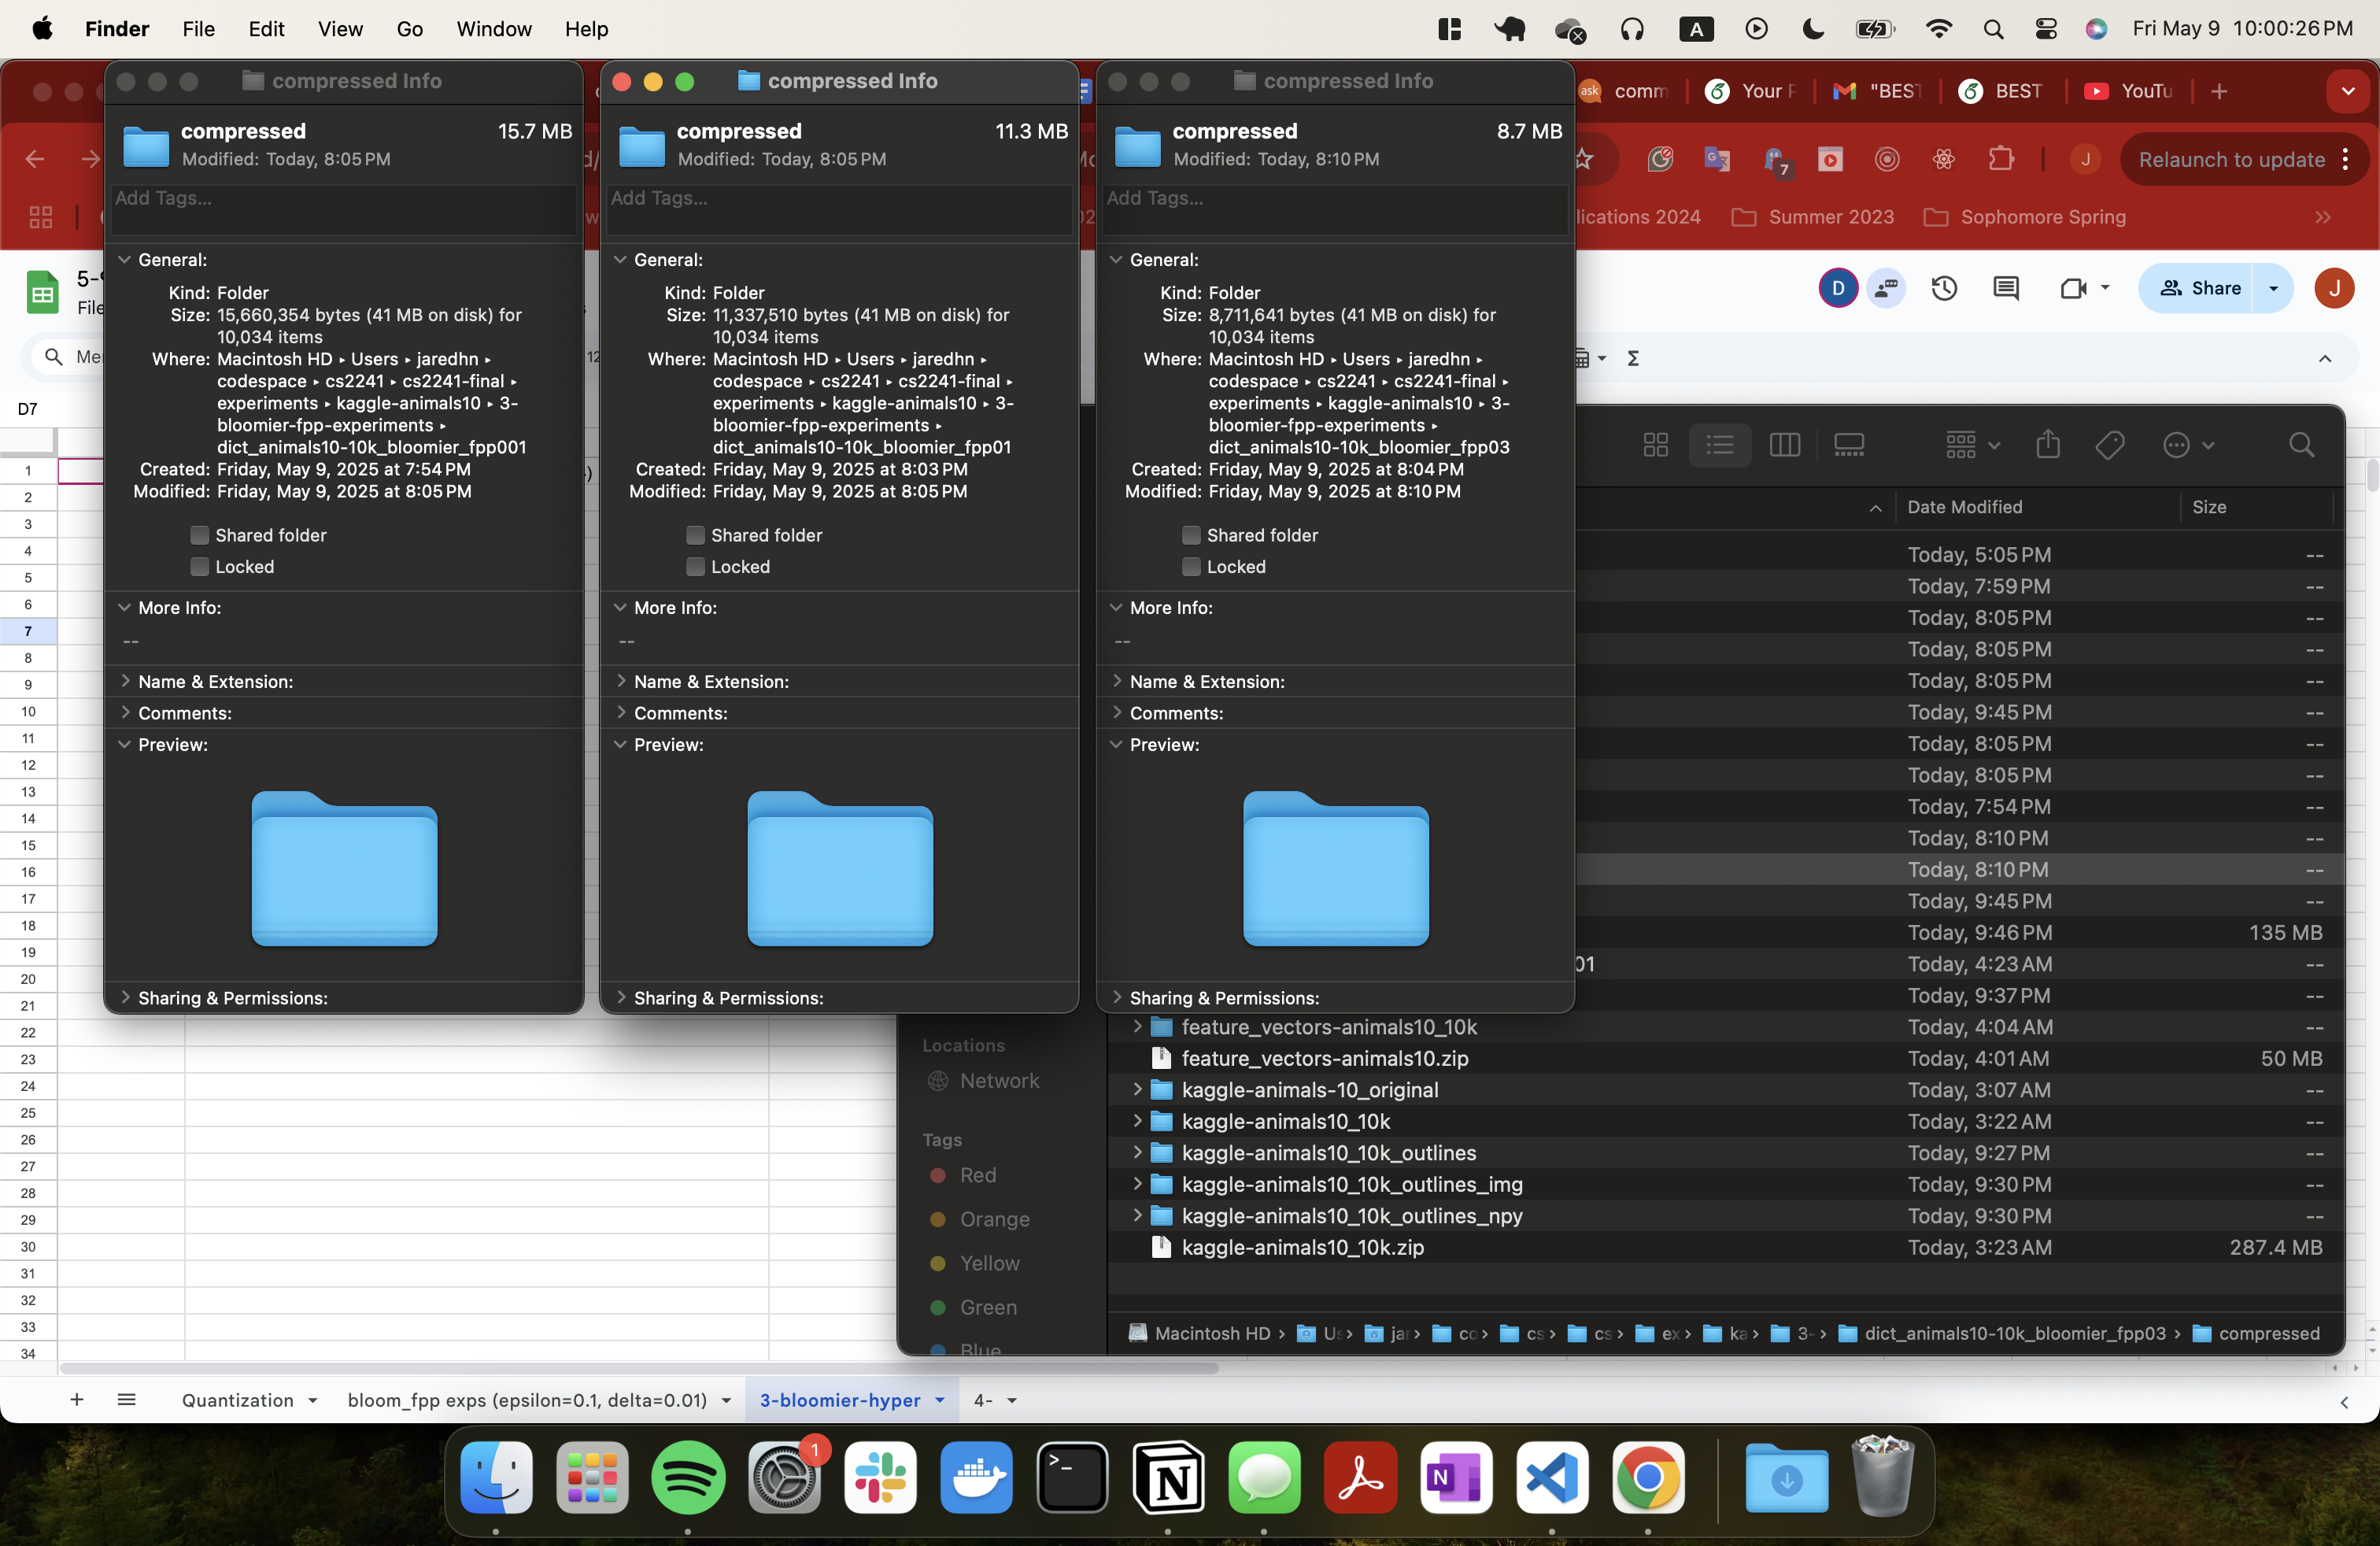

In [19]:
# SIZES FOR THE QUANTIZATION LEVELS:


from IPython.display import Image, display

# Replace 'screenshot.png' with the actual name of your uploaded file
file_name = 'bloomier-size.png'
display(Image(filename=file_name))

# file_name = 'size_change-epp.png'
# display(Image(filename=file_name))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

input_size = (128, 128)
batch_size = 128

augmentor = ImageDataGenerator(samplewise_center=True,
                               samplewise_std_normalization=True)

train_generator = augmentor.flow_from_directory(
    '/kaggle/split_data/train',
    target_size=input_size,
    batch_size=batch_size,
    shuffle=True
)

val_generator = augmentor.flow_from_directory(
    '/kaggle/split_data/val',
    target_size=input_size,
    batch_size=batch_size,
    shuffle=False
)

test_generator = augmentor.flow_from_directory(
    '/kaggle/split_data/test',
    target_size=input_size,
    batch_size=batch_size,
    shuffle=False
)

Found 19998 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [ ]:
num_classes = len(train_generator.class_indices)
input_shape = (128,128,3)

2


In [ ]:
model = Sequential([
    Input(shape = input_shape),
    Conv2D (32, kernel_size = (3,3), activation= "relu"),
    Conv2D (32, kernel_size = (3,3), activation= "relu"),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),


    Conv2D (64, kernel_size = (3,3), activation= "relu"),
    Conv2D (64, kernel_size = (3,3), activation= "relu"),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),


    Conv2D (128, kernel_size = (3,3), activation= "relu"),
    Conv2D (128, kernel_size = (3,3), activation= "relu"),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    Conv2D (256, kernel_size = (3,3), activation= "relu"),
    Conv2D (256, kernel_size = (3,3), activation= "relu"),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation = 'relu'),
    Dense(128 , activation = 'relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam',
             loss= 'categorical_crossentropy',
             metrics =["accuracy"])
model.summary()

Model Layers:
0 conv2d N/A
1 conv2d_1 N/A
2 max_pooling2d N/A
3 dropout N/A
4 conv2d_2 N/A
5 conv2d_3 N/A
6 max_pooling2d_1 N/A
7 dropout_1 N/A
8 conv2d_4 N/A
9 conv2d_5 N/A
10 max_pooling2d_2 N/A
11 dropout_2 N/A
12 conv2d_6 N/A
13 conv2d_7 N/A
14 final_pool_layer N/A
15 dropout_3 N/A
16 flatten N/A
17 dense N/A
18 dense_1 N/A
19 dropout_4 N/A
20 dense_2 N/A


In [ ]:
model.fit(train_generator,
          epochs=15,
          validation_data=val_generator)

Epoch 1/15
  6/157 ━━━━━━━━━━━━━━━━━━━━ 25s 168ms/step - accuracy: 0.4882 - loss: 0.7747

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.5164 - loss: 0.6986

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


157/157 ━━━━━━━━━━━━━━━━━━━━ 67s 316ms/step - accuracy: 0.5167 - loss: 0.6984 - val_accuracy: 0.6452 - val_loss: 0.6299
Epoch 2/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 230ms/step - accuracy: 0.6764 - loss: 0.5975 - val_accuracy: 0.6960 - val_loss: 0.5981
Epoch 3/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 231ms/step - accuracy: 0.7258 - loss: 0.5476 - val_accuracy: 0.7588 - val_loss: 0.5115
Epoch 4/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 230ms/step - accuracy: 0.7601 - loss: 0.4934 - val_accuracy: 0.7696 - val_loss: 0.4738
Epoch 5/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 227ms/step - accuracy: 0.7958 - loss: 0.4378 - val_accuracy: 0.8096 - val_loss: 0.4096
Epoch 6/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 227ms/step - accuracy: 0.8291 - loss: 0.3863 - val_accuracy: 0.8372 - val_loss: 0.3638
Epoch 7/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 231ms/step - accuracy: 0.8541 - loss: 0.3394 - val_accuracy: 0.8708 - val_loss: 0.3125
Epoch 8/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 231ms/step - accuracy: 0.8712 - loss: 0.2992 - val

In [ ]:
try:
    # Try accessing the model's input tensor if build worked correctly
    # (This is what *should* work)
    model_input_tensor = model.input
    if model_input_tensor is None: # Check if it's None
         raise AttributeError # Force fallback if None
    print("Using model.input")
except AttributeError:
    try:
        # Fallback: If Input() is the first layer *in the list*:
        model_input_tensor = model.layers[0].output
        print("Using model.layers[0].output")
         # This might actually get the output of the *first Conv layer* if Input isn't counted
         # Need to be careful. Let's try model.inputs list
        if isinstance(model.inputs, list) and len(model.inputs) > 0:
             model_input_tensor = model.inputs[0]
             print("Using model.inputs[0]")
        else:
             # If the above fail, maybe the input layer NAME works?
             model_input_tensor = model.get_layer(index=0).output # Try getting layer 0 output by index
             print("Using model.get_layer(index=0).output")

    except Exception as e:
        print(f"Error getting input tensor: {e}")
        print("Could not reliably determine the input tensor. Consider defining Input() outside the Sequential list.")
        # Handle error appropriately - maybe exit or raise
        raise ValueError("Cannot find the input tensor for the feature extractor.") from e


# Identify the target layer by name (more robust)
target_layer_name = 'final_pool_layer'
target_output = model.get_layer(target_layer_name).output

# Create a new Model using the input tensor we found
feature_extractor_model = Model(inputs=model_input_tensor, outputs=target_output, name="feature_extractor")

print("\n--- Feature Extractor Model Summary ---")
# Need to build the extractor model too before summary sometimes
feature_extractor_model.build(input_shape=(None,) + input_shape)
feature_extractor_model.summary()

def load_and_preprocess_image(image_path, target_shape):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_shape[:2])
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

image_path = '/kaggle/split_data/test/Cat/100.jpg'
try:
    # Create a dummy image if needed for testing:
    dummy_data = np.random.rand(input_shape[0], input_shape[1], input_shape[2]) * 255
    tf.keras.preprocessing.image.save_img(image_path, dummy_data)
except Exception as e:
    print(f"Could not create dummy image: {e}. Please provide a real image path.")
    exit()


preprocessed_image = load_and_preprocess_image(image_path, input_shape)

# Use the feature_extractor_model to get the feature map
feature_map = feature_extractor_model.predict(preprocessed_image)

print(f"\nShape of extracted feature map: {feature_map.shape}")

# Clean up dummy image if created
import os
if os.path.exists(image_path):
    try:
        os.remove(image_path)
    except OSError as e:
        print(f"Error removing dummy image: {e}")
"""
0 conv2d_56 N/A
1 conv2d_57 N/A
2 max_pooling2d_23 N/A
3 dropout_35 N/A
4 conv2d_58 N/A
5 conv2d_59 N/A
6 max_pooling2d_24 N/A
7 dropout_36 N/A
8 conv2d_60 N/A
9 conv2d_61 N/A
10 max_pooling2d_25 N/A
11 dropout_37 N/A
12 conv2d_62 N/A
13 conv2d_63 N/A
14 final_pool_layer N/A
"""

Using model.layers[0].output
Using model.inputs[0]

--- Feature Extractor Model Summary ---


Model: "feature_extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 58, 58, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 27, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ final_pool_layer (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,172,256 (4.47 MB)

 Trainable params: 1,172,256 (4.47 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step

Shape of extracted feature map: (1, 4, 4, 256)


'\n0 conv2d_56 N/A\n1 conv2d_57 N/A\n2 max_pooling2d_23 N/A\n3 dropout_35 N/A\n4 conv2d_58 N/A\n5 conv2d_59 N/A\n6 max_pooling2d_24 N/A\n7 dropout_36 N/A\n8 conv2d_60 N/A\n9 conv2d_61 N/A\n10 max_pooling2d_25 N/A\n11 dropout_37 N/A\n12 conv2d_62 N/A\n13 conv2d_63 N/A\n14 final_pool_layer N/A\n'

In [ ]:
# print(f"\nExtracted feature map: {feature_map}")

import numpy as np
import os # For checking file existence
import sys

log_filename = "inference_log.txt"
print(f"Attempting to write feature map details to '{log_filename}'...")


# Make sure feature_map exists before proceeding
if 'feature_map' not in locals() and 'feature_map' not in globals():
    print("Error: 'feature_map' variable not found. Please ensure it was generated.")
else:
    # --- WARNING ---
    total_elements = np.prod(feature_map.shape)
    print(f"[WARNING] Feature map has {total_elements} elements.")
    if total_elements > 10000: # Arbitrary threshold for warning
        print(f"[WARNING] Writing all elements might create a very large log file (> {total_elements * 5 // 1024} KB approx) and could be slow.")
    # -------------

    try:
        with open(log_filename, 'w') as log_file: # Use 'w' to overwrite each time for full logs
            log_file.write("--- Full Extracted Feature Map ---\n")
            log_file.write(f"Timestamp: {np.datetime64('now')}\n")
            log_file.write(f"Shape: {feature_map.shape}\n")
            log_file.write(f"Data Type: {feature_map.dtype}\n")
            log_file.write(f"Min value: {np.min(feature_map)}\n")
            log_file.write(f"Max value: {np.max(feature_map)}\n")
            log_file.write(f"Mean value: {np.mean(feature_map)}\n")
            log_file.write(f"Std Dev: {np.std(feature_map)}\n")
            log_file.write("\nFeature Map Content (Full):\n")

            # Option 2 (Modified): Write the FULL array content
            # Use threshold=sys.maxsize or np.inf to disable summarization
            feature_map_string = np.array2string(
                feature_map,
                precision=6,          # Increase precision if needed
                suppress_small=False, # Show small numbers accurately
                max_line_width=150,   # Wider lines might help for large arrays
                threshold=sys.maxsize # Force printing the entire array
                # threshold=np.inf   # Alternative way to force printing all
            )
            log_file.write(feature_map_string)

            log_file.write("\n--- End Full Feature Map ---\n")

        print(f"Successfully wrote FULL feature map to '{log_filename}'")

    except Exception as e:
        print(f"Error writing to log file '{log_filename}': {e}")

Attempting to write feature map details to 'inference_log.txt'...
Error: 'feature_map' variable not found. Please ensure it was generated.


In [ ]:
# --- 1. Create the "Classifier Head" Model ---

# Find the index of the layer RIGHT AFTER our feature extraction layer ('final_pool_layer')
# This is where the classifier head starts.
feature_layer_name = 'final_pool_layer'
try:
    # Find the index of the layer by name
    feature_layer_index = [i for i, layer in enumerate(model.layers) if layer.name == feature_layer_name][0]
    classifier_start_index = feature_layer_index + 1
    print(f"Feature extraction layer ('{feature_layer_name}') index: {feature_layer_index}")
    print(f"Classifier head starts at layer index: {classifier_start_index}")
except IndexError:
    print(f"Error: Could not find layer named '{feature_layer_name}' in the original model.")
    # Handle error appropriately
    exit()
except Exception as e:
    print(f"An error occurred finding the layer index: {e}")
    exit()


# Define an Input layer matching the shape of the feature map (excluding batch dimension)
feature_map_shape = feature_map.shape[1:]
classifier_input = Input(shape=feature_map_shape, name="feature_map_input")

# connect
x = classifier_input
for i in range(classifier_start_index, len(model.layers)):
    original_layer = model.layers[i]
    x = original_layer(x, training=False)
    print(f"Added layer {i}: {original_layer.name}")

classifier_model = Model(inputs=classifier_input, outputs=x, name="classifier_head")

print("\n--- Classifier Head Model Summary ---")
classifier_model.summary()

"""
15 dropout_33 N/A
16 flatten_6 N/A
17 dense_18 N/A
18 dense_19 N/A
19 dropout_34 N/A
20 dense_20 N/A
"""

Feature extraction layer ('final_pool_layer') index: 14
Classifier head starts at layer index: 15
Added layer 15: dropout_38
Added layer 16: flatten_7
Added layer 17: dense_21
Added layer 18: dense_22
Added layer 19: dropout_39
Added layer 20: dense_23

--- Classifier Head Model Summary ---


Model: "classifier_head"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_map_input (InputLayer)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,081,986 (4.13 MB)

 Trainable params: 1,081,986 (4.13 MB)

 Non-trainable params: 0 (0.00 B)

'\n15 dropout_33 N/A\n16 flatten_6 N/A\n17 dense_18 N/A\n18 dense_19 N/A\n19 dropout_34 N/A\n20 dense_20 N/A\n'

In [ ]:

final_predictions = classifier_model.predict(feature_map)

print(f"\nShape of final predictions: {final_predictions.shape}") # Should be (1, num_classes)
print(f"Raw predictions (probabilities):\n{final_predictions}")

predicted_class_index = np.argmax(final_predictions, axis=1)[0]
print(f"\nPredicted class index: {predicted_class_index}")

print("\n--- Verifying with original model ---")

# (Need to load the image again if not available)
image_path = '/kaggle/split_data/test/Cat/11530.jpg'

if not os.path.exists(image_path):
    try:
        print("Creating dummy image for verification...")
        dummy_data = np.random.rand(input_shape[0], input_shape[1], input_shape[2]) * 255
        tf.keras.preprocessing.image.save_img(image_path, dummy_data)
    except Exception as e:
        print(f"Could not create dummy image: {e}.")
else:
    def load_and_preprocess_image(image_path, target_shape):
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_shape[:2])
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0
        return img_array

    preprocessed_image_for_full_model = load_and_preprocess_image(image_path, input_shape)
    original_model_predictions = model.predict(preprocessed_image_for_full_model)
    original_predicted_class_index = np.argmax(original_model_predictions, axis=1)[0]

    print(f"Original model predicted index: {original_predicted_class_index}")
    print(f"Feature map pipeline predicted index: {predicted_class_index}")

    # Check if predictions are numerically close (they should be almost identical)
    if np.allclose(final_predictions, original_model_predictions, atol=1e-6):
        print("SUCCESS: Predictions from split model match original model (before compression).")
    else:
        print("WARNING: Predictions from split model DO NOT match original model.")
        print("Original:", original_model_predictions)
        print("Split:", final_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Shape of final predictions: (1, 2)
Raw predictions (probabilities):
[[0.75012386 0.24987611]]

Predicted class index: 0

--- Verifying with original model ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Original model predicted index: 0
Feature map pipeline predicted index: 0
Original: [[0.7234268  0.27657315]]
Split: [[0.75012386 0.24987611]]
